# Análisis exploratorio del rendimiento escolar

Exploración basada en `data/raw/rendimiento_escolar.csv`, siguiendo los lineamientos del documento `references/PresentacionCaso.pdf`.

## Objetivos del caso

- Caracterizar la distribución del `PROM_GRAL` y la `ASISTENCIA` por rangos, resaltando segmentos críticos.
- Cruzar desempeño y asistencia con las variables de contexto pedidas (género, dependencia y región) para identificar brechas territoriales o administrativas.
- Preparar visualizaciones solicitadas en la guía: barras comparativas, mapas de calor regionales y la relación asistencia vs. rendimiento.
- Entrenar una regresión lineal simple que cuantifique los efectos marginales de la asistencia y las variables de contexto sobre el promedio general.

In [20]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 120
pd.options.display.float_format = "{:,.2f}".format

RANDOM_STATE = 42

In [21]:
DATA_PATH = Path("../data/raw/rendimiento_escolar.csv")

# Se especifica el separador decimal y los tipos de datos para optimizar la carga
raw_df = pd.read_csv(DATA_PATH, decimal=",")
df = raw_df.copy()

# La columna PROM_GRAL ya se carga como float gracias al parámetro 'decimal'
# df["PROM_GRAL"] = (
#     df["PROM_GRAL"].astype(str).str.replace(",", ".", regex=False).astype(float)
# )

region_cols = [c for c in df.columns if c.startswith("COD_REG_RBD_")]
dep_cols = [c for c in df.columns if c.startswith("COD_DEPE_")]
gender_cols = [c for c in df.columns if c.startswith("GEN_ALU_")]

def collapse_one_hot(frame, columns, prefix="", mapping=None):
    relevant = frame[columns]
    labels = relevant.idxmax(axis=1)
    labels = labels.where(relevant.sum(axis=1).gt(0))
    labels = labels.str.replace(prefix, "", regex=False).str.strip()
    if mapping:
        labels = labels.map(mapping).fillna(labels)
    return labels

GEN_MAP = {
    "GEN_ALU_0": "Indefinido",
    "GEN_ALU_1": "Masculino",
    "GEN_ALU_2": "Femenino",
    "GEN_ALU_0": "Sin información",
    "GEN_ALU_3": "No Binario",
}

df["region"] = collapse_one_hot(df, region_cols, "COD_REG_RBD_")
df["dependencia"] = collapse_one_hot(df, dep_cols, "COD_DEPE_")
df["genero"] = collapse_one_hot(df, gender_cols, mapping=GEN_MAP)

valid_mask = df["PROM_GRAL"].between(1, 7)
df_valid = df[valid_mask].copy()

print(f"Registros totales: {len(df):,}")
print(f"Registros con PROM_GRAL válido (1-7): {len(df_valid):,} ({len(df_valid)/len(df):.1%})")
display(df_valid[["ASISTENCIA", "PROM_GRAL", "region", "dependencia", "genero"]].head())

Registros totales: 840,352
Registros con PROM_GRAL válido (1-7): 769,165 (91.5%)


,ASISTENCIA,PROM_GRAL,region,dependencia,genero
0,80,6.20,Arica y Parinacota,Servicio Local de Educación,Masculino
2,81,5.40,Arica y Parinacota,Servicio Local de Educación,Masculino
3,85,6.50,Arica y Parinacota,Servicio Local de Educación,Masculino
4,73,4.90,Arica y Parinacota,Servicio Local de Educación,Masculino
5,89,5.80,Arica y Parinacota,Servicio Local de Educación,Masculino


## 1. Panorama general de la base

- `PROM_GRAL` viene con coma decimal y se transforma a flotante.
- Se consideran válidos únicamente los promedios en la escala oficial de 1 a 7; los registros fuera del rango se tratan como “sin nota” para los análisis de desempeño.
- Se crean las columnas `region`, `dependencia` y `genero` a partir de los indicadores one-hot entregados.

In [22]:
metrics_table = (
    df_valid[["PROM_GRAL", "ASISTENCIA"]]
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    .T
)
metrics_table["missing_pct"] = [
    (1 - len(df_valid) / len(df)) * 100,
    df_valid["ASISTENCIA"].isna().mean() * 100,
]
display(metrics_table)

context_coverage = (
    df_valid[["region", "dependencia", "genero"]]
    .isna()
    .mean()
    .to_frame(name="missing_pct")
)
display(context_coverage)

corr_global = df_valid["PROM_GRAL"].corr(df_valid["ASISTENCIA"])
print(f"Correlación PROM_GRAL vs. ASISTENCIA: {corr_global:.3f}")

,count,mean,std,min,10%,25%,50%,75%,90%,max,missing_pct
PROM_GRAL,"769,165.00",5.92,0.66,1.00,5.10,5.50,6.00,6.40,6.70,7.00,8.47
ASISTENCIA,"769,165.00",89.37,11.08,0.00,79.00,86.00,92.00,96.00,99.00,100.00,0.00


,missing_pct
region,0.00
dependencia,0.00
genero,0.00


Correlación PROM_GRAL vs. ASISTENCIA: 0.366


### Distribuciones por rangos

La guía solicita caracterizar los tramos de rendimiento y asistencia. Se generan tablas de frecuencia y diagramas de densidad para ambos indicadores.

,estudiantes,pct
prom_rango,,
1.0-3.0,1808,0.24
3.0-4.0,5122,0.67
4.0-5.0,68340,8.88
5.0-6.0,331403,43.09
6.0-7.0,362492,47.13


,estudiantes,pct
asistencia_rango,,
0-50,12843,1.67
50-80,80028,10.40
80-90,232194,30.19
90-95,216574,28.16
95-100,227526,29.58


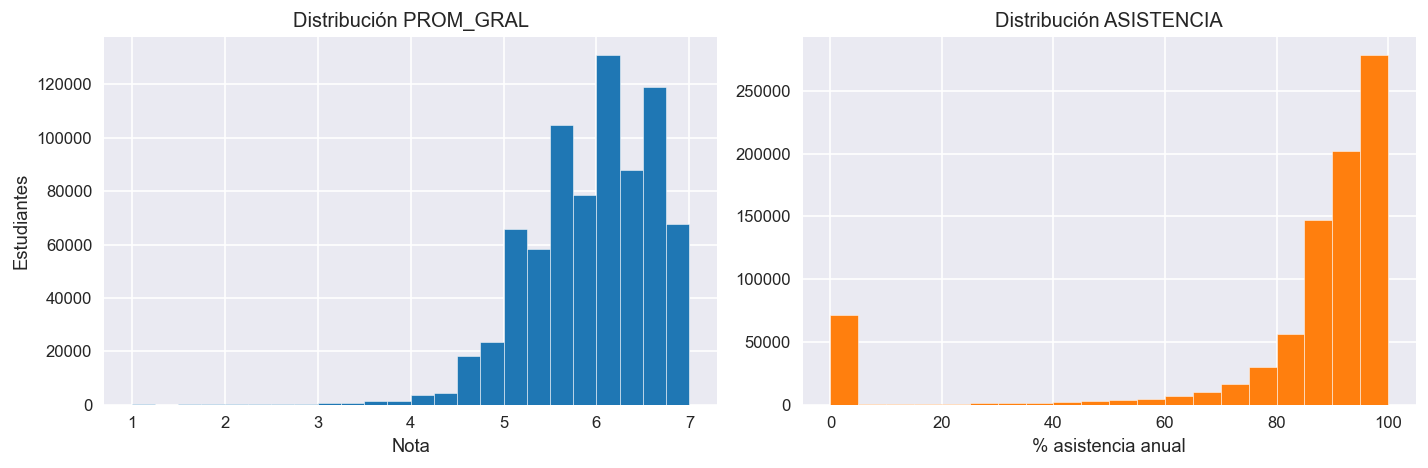

In [23]:
prom_bins = [1, 3, 4, 5, 6, 7.1]
prom_labels = ["1.0-3.0", "3.0-4.0", "4.0-5.0", "5.0-6.0", "6.0-7.0"]
df_valid["prom_rango"] = pd.cut(
    df_valid["PROM_GRAL"],
    bins=prom_bins,
    labels=prom_labels,
    include_lowest=True,
)

asistencia_bins = [0, 50, 80, 90, 95, 100]
asistencia_labels = ["0-50", "50-80", "80-90", "90-95", "95-100"]
df_valid["asistencia_rango"] = pd.cut(
    df_valid["ASISTENCIA"],
    bins=asistencia_bins,
    labels=asistencia_labels,
    include_lowest=True,
    right=True,
)

freq_prom = (
    df_valid["prom_rango"]
    .value_counts()
    .sort_index()
    .to_frame(name="estudiantes")
)
freq_prom["pct"] = 100 * freq_prom["estudiantes"] / freq_prom["estudiantes"].sum()

freq_asistencia = (
    df_valid["asistencia_rango"]
    .value_counts()
    .sort_index()
    .to_frame(name="estudiantes")
)
freq_asistencia["pct"] = (
    100 * freq_asistencia["estudiantes"] / freq_asistencia["estudiantes"].sum()
)

display(freq_prom)
display(freq_asistencia)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(
    df_valid["PROM_GRAL"],
    bins=np.arange(1, 7.25, 0.25),
    color="#1f77b4",
    edgecolor="white",
)
axes[0].set_title("Distribución PROM_GRAL")
axes[0].set_xlabel("Nota")
axes[0].set_ylabel("Estudiantes")

axes[1].hist(
    df["ASISTENCIA"],
    bins=np.arange(0, 105, 5),
    color="#ff7f0e",
    edgecolor="white",
)
axes[1].set_title("Distribución ASISTENCIA")
axes[1].set_xlabel("% asistencia anual")

plt.tight_layout()
plt.show()

## 2. Cruces con variables de contexto

Se evalúan medias, dispersiones y tamaños de muestra por dependencia, género y región; luego se derivan visualizaciones comparativas solicitadas en la guía.

In [24]:
def summarize_context(group_col):
    summary = (
        df_valid.groupby(group_col)[["PROM_GRAL", "ASISTENCIA"]]
        .agg(["mean", "std", "count"])
        .sort_values(("PROM_GRAL", "mean"), ascending=False)
    )
    summary.columns = [f"{metric}_{stat}" for metric, stat in summary.columns]
    return summary

dep_summary = summarize_context("dependencia")
gender_summary = summarize_context("genero")
region_summary = summarize_context("region")

display(dep_summary)
display(gender_summary)
display(region_summary.head(10))

,PROM_GRAL_mean,PROM_GRAL_std,PROM_GRAL_count,ASISTENCIA_mean,ASISTENCIA_std,ASISTENCIA_count
dependencia,,,,,,
Particular Pagado (o no subvencionado),6.30,0.48,94799,92.20,7.09,94799
Particular Subvencionado,5.91,0.64,411388,89.80,10.62,411388
Municipal DAEM,5.85,0.71,136333,88.44,12.10,136333
Servicio Local de Educación,5.82,0.73,37887,87.18,12.77,37887
Corporación Municipal,5.79,0.70,66999,87.16,12.93,66999
Corporación de Administración Delegada (DL 3166),5.58,0.73,21759,85.15,13.69,21759


,PROM_GRAL_mean,PROM_GRAL_std,PROM_GRAL_count,ASISTENCIA_mean,ASISTENCIA_std,ASISTENCIA_count
genero,,,,,,
Femenino,6.03,0.64,380001,88.88,11.51,380001
Masculino,5.82,0.67,389163,89.84,10.62,389163
Sin información,5.10,NaN,1,96.00,NaN,1


,PROM_GRAL_mean,PROM_GRAL_std,PROM_GRAL_count,ASISTENCIA_mean,ASISTENCIA_std,ASISTENCIA_count
region,,,,,,
Arica y Parinacota,6.11,0.61,9990,90.06,10.12,9990
Magallanes,6.01,0.58,6569,88.81,9.76,6569
Biobío,5.98,0.65,67317,89.02,11.25,67317
Valparaíso,5.98,0.64,77655,89.16,10.91,77655
Maule,5.97,0.67,41691,90.98,10.17,41691
Ñuble,5.97,0.67,22591,90.14,11.42,22591
Antofagasta,5.95,0.63,26345,89.26,10.52,26345
Tarapacá,5.95,0.64,16142,88.89,10.86,16142
Los Ríos,5.95,0.65,16292,90.79,10.06,16292


In [25]:
def add_labels_to_barh(ax, fmt="{:.2f}"):
    """Añade etiquetas a las barras de un gráfico de barras horizontal."""
    for bar in ax.patches:
        width = bar.get_width()
        # Ajustar la posición x para valores negativos
        x_pos = width + (ax.get_xlim()[1] * 0.01) if width >= 0 else width - (ax.get_xlim()[1] * 0.05)
        ax.text(
            x_pos,
            bar.get_y() + bar.get_height() / 2,
            fmt.format(width),
            va='center',
        )
    # Ajustar límites para dar espacio a las etiquetas
    ax.set_xlim(right=ax.get_xlim()[1] * 1.15)

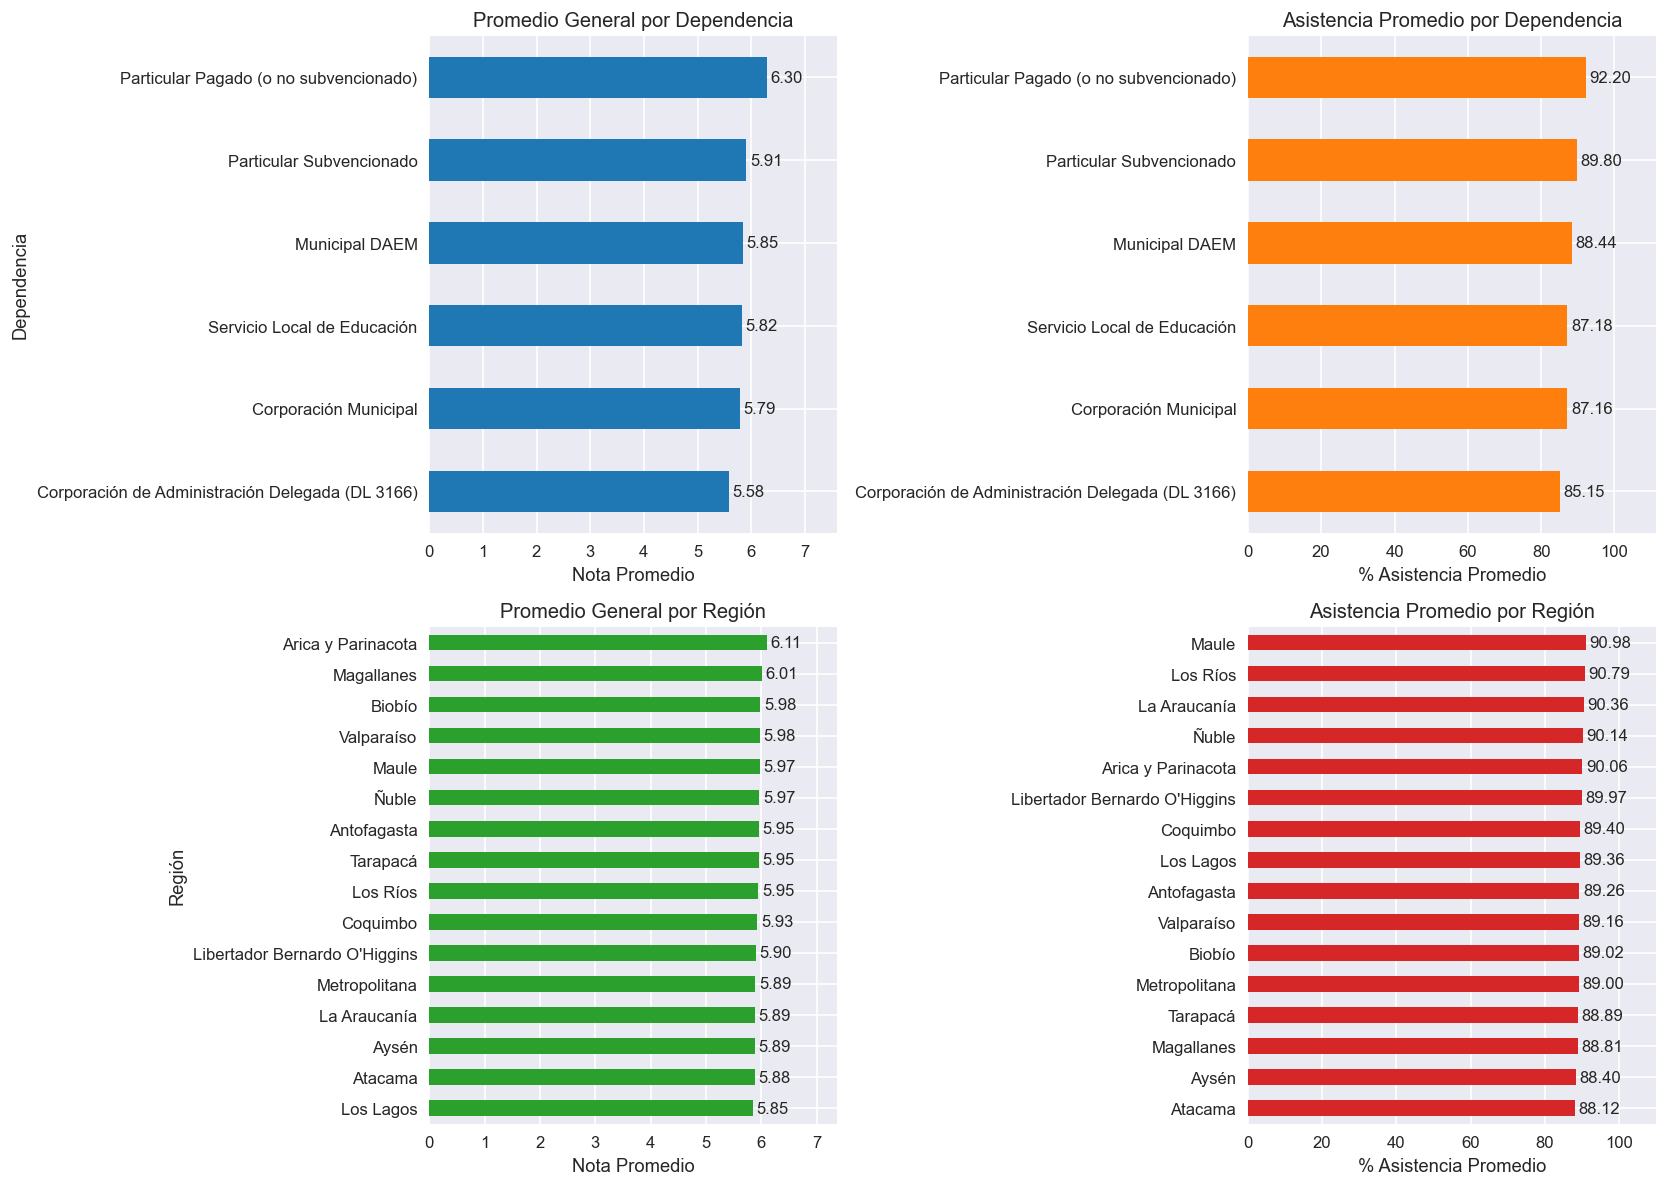

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Gráficos por Dependencia ---
dep_summary_sorted = dep_summary.sort_values("PROM_GRAL_mean")

# Gráfico para PROM_GRAL por Dependencia
dep_summary_sorted["PROM_GRAL_mean"].plot(
    kind="barh", ax=axes[0, 0], color="#1f77b4", title="Promedio General por Dependencia"
)
axes[0, 0].set_xlabel("Nota Promedio")
axes[0, 0].set_ylabel("Dependencia")
add_labels_to_barh(axes[0, 0])

# Gráfico para ASISTENCIA por Dependencia
dep_summary_sorted["ASISTENCIA_mean"].plot(
    kind="barh", ax=axes[0, 1], color="#ff7f0e", title="Asistencia Promedio por Dependencia"
)
axes[0, 1].set_xlabel("% Asistencia Promedio")
axes[0, 1].set_ylabel("")
add_labels_to_barh(axes[0, 1])

# --- Gráficos por Región ---
region_prom_plot = (
    df_valid.groupby("region")["PROM_GRAL"]
    .mean()
    .sort_values()
)
region_prom_plot.plot(kind="barh", ax=axes[1, 0], color="#2ca02c")
axes[1, 0].set_title("Promedio General por Región")
axes[1, 0].set_xlabel("Nota Promedio")
axes[1, 0].set_ylabel("Región")
add_labels_to_barh(axes[1, 0])

region_asistencia_plot = (
    df_valid.groupby("region")["ASISTENCIA"]
    .mean()
    .sort_values()
)
region_asistencia_plot.plot(kind="barh", ax=axes[1, 1], color="#d62728")
axes[1, 1].set_title("Asistencia Promedio por Región")
axes[1, 1].set_xlabel("% Asistencia Promedio")
axes[1, 1].set_ylabel("")
add_labels_to_barh(axes[1, 1])

plt.tight_layout()
plt.show()

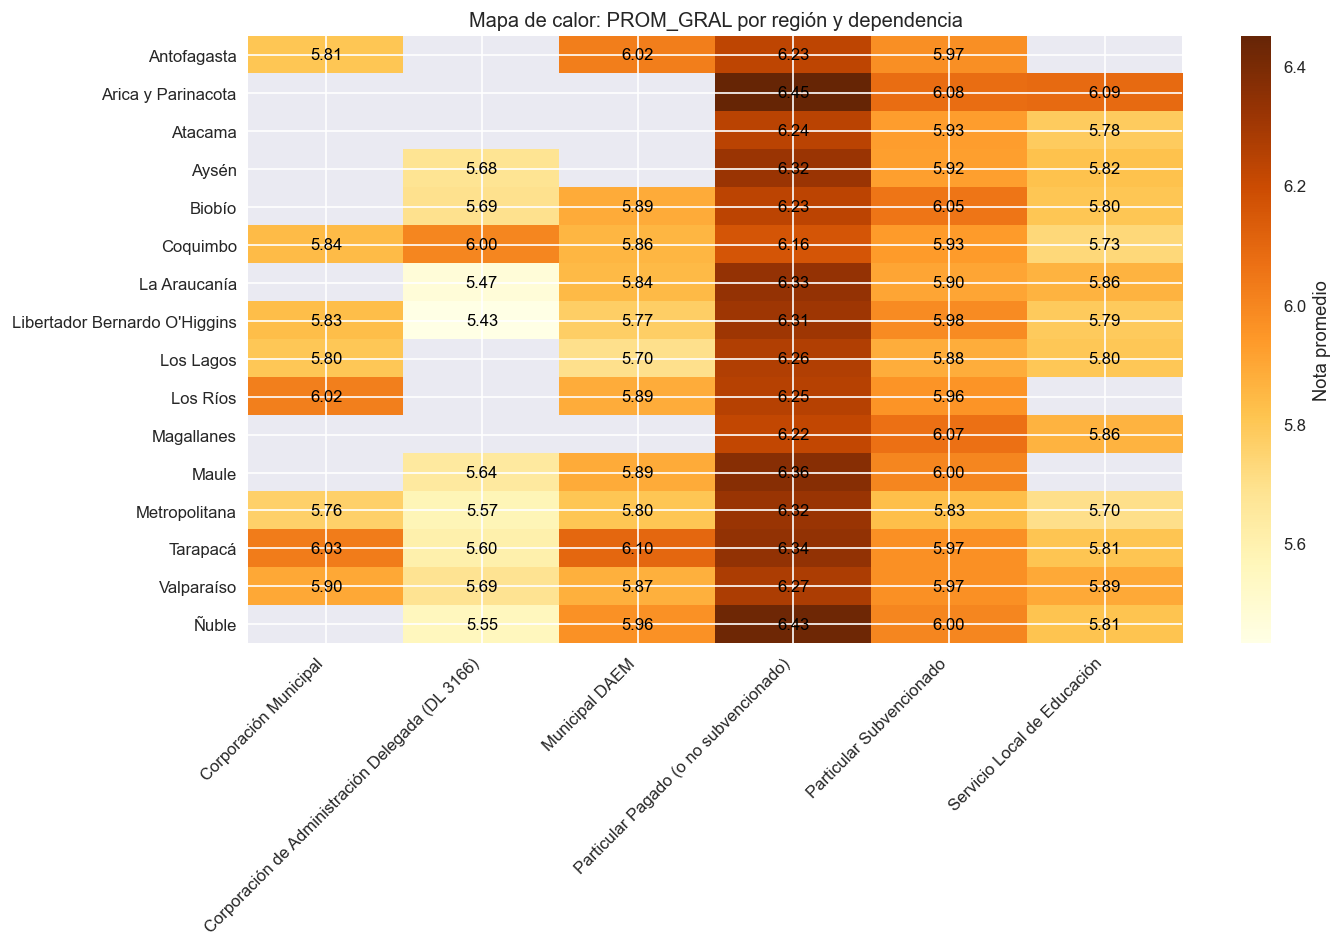

In [27]:
heatmap_data = df_valid.pivot_table(
    index="region",
    columns="dependencia",
    values="PROM_GRAL",
    aggfunc="mean",
)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(heatmap_data.values, aspect="auto", cmap="YlOrBr")
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha="right")
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index)
ax.set_title("Mapa de calor: PROM_GRAL por región y dependencia")

for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.values[i, j]
        if np.isnan(value):
            continue
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

fig.colorbar(im, ax=ax, label="Nota promedio")
plt.tight_layout()
plt.show()

## 3. Relación asistencia vs. rendimiento

La presentación pide analizar la variación conjunta de ambos indicadores.

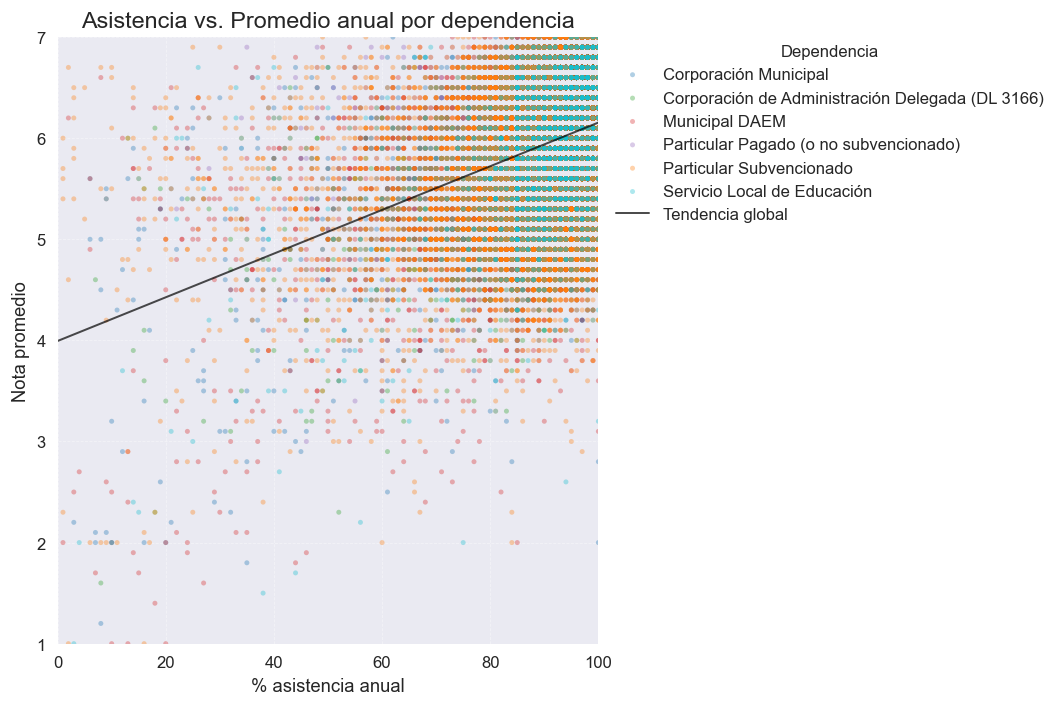

In [31]:
# asumir que df_valid ya existe

sample = (
    df_valid.sample(50_000, random_state=RANDOM_STATE)
    if len(df_valid) > 50_000
    else df_valid
)

# paleta fija por si cambian los órdenes
deps = sorted(sample["dependencia"].unique())
colors = {
    dep: col for dep, col in zip(
        deps,
        ["#1f77b4", "#2ca02c", "#d62728", "#9467bd", "#ff7f0e", "#17becf"]
    )
}

fig, ax = plt.subplots(figsize=(9, 6))

for dep, data in sample.groupby("dependencia"):
    ax.scatter(
        data["ASISTENCIA"],
        data["PROM_GRAL"],
        s=9,               # un poco más chico
        alpha=0.35,        # más transparencia
        color=colors.get(dep, "#999999"),
        label=dep,
        edgecolors="none"
    )

# (opcional) línea de tendencia global
z = np.polyfit(sample["ASISTENCIA"], sample["PROM_GRAL"], 1)
x_line = np.linspace(0, 100, 100)
y_line = np.polyval(z, x_line)
ax.plot(x_line, y_line, color="black", linewidth=1.2, alpha=0.7, label="Tendencia global")

ax.set_title("Asistencia vs. Promedio anual por dependencia", fontsize=14)
ax.set_xlabel("% asistencia anual")
ax.set_ylabel("Nota promedio")

ax.set_xlim(0, 100)
ax.set_ylim(1, 7)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)

# leyenda fuera
ax.legend(
    title="Dependencia",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# asumir que df_valid ya existe
RANDOM_STATE = 42

sample = (
    df_valid.sample(50_000, random_state=RANDOM_STATE)
    if len(df_valid) > 50_000
    else df_valid
)

# paleta fija por si cambian los órdenes
deps = sorted(sample["dependencia"].unique())
colors = {
    dep: col for dep, col in zip(
        deps,
        ["#1f77b4", "#2ca02c", "#d62728", "#9467bd", "#ff7f0e", "#17becf"]
    )
}

# ============================================================
# 1) LINEPLOT: promedio de nota vs asistencia por dependencia
# ============================================================

# redondeamos asistencia para agrupar
sample["asist_rounded"] = sample["ASISTENCIA"].round(0)

# calculamos promedio por dependencia y % asistencia
mean_by_dep = (
    sample
    .groupby(["dependencia", "asist_rounded"])["PROM_GRAL"]
    .mean()
    .reset_index()
    .sort_values(["dependencia", "asist_rounded"])
)

fig, ax = plt.subplots(figsize=(9, 6))

for dep in deps:
    data_dep = mean_by_dep[mean_by_dep["dependencia"] == dep]
    ax.plot(
        data_dep["asist_rounded"],
        data_dep["PROM_GRAL"],
        label=dep,
        color=colors.get(dep, "#999999"),
        linewidth=1.5,
        marker="o",
        markersize=3,
        alpha=0.9
    )

ax.set_title("Promedio de nota vs asistencia (agrupado)", fontsize=14)
ax.set_xlabel("% asistencia anual (redondeado)")
ax.set_ylabel("Nota promedio")
ax.set_xlim(0, 100)
ax.set_ylim(1, 7)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
ax.legend(
    title="Dependencia",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()


In [ ]:

# ============================================================
# 2) BOXPLOT por tramos de asistencia y dependencia (matplotlib puro)
# ============================================================

# definimos tramos
bins = [0, 60, 70, 80, 90, 100]
labels = ["≤60", "60-70", "70-80", "80-90", "90-100"]

sample["tramo_asistencia"] = pd.cut(
    sample["ASISTENCIA"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

tramos = labels  # orden fijo

fig, ax = plt.subplots(figsize=(11, 6))

# vamos a hacer un boxplot "agrupado":
# por cada tramo, ponemos uno por dependencia con un pequeño desplazamiento
n_deps = len(deps)
width = 0.8  # ancho total usado por tramo
gap = width / n_deps  # separación entre box de cada dependencia

# para poner los xticks al centro
xtick_positions = []

for i, tramo in enumerate(tramos):
    # data de este tramo
    tramo_data = sample[sample["tramo_asistencia"] == tramo]

    base_pos = i + 1  # posición base de este tramo
    xtick_positions.append(base_pos)

    for j, dep in enumerate(deps):
        dep_data = tramo_data[tramo_data["dependencia"] == dep]["PROM_GRAL"].dropna()

        # si no hay datos, saltamos
        if dep_data.empty:
            continue

        # posición para este box
        pos = base_pos - width/2 + (j + 0.5) * gap

        bp = ax.boxplot(
            dep_data,
            positions=[pos],
            widths=gap * 0.8,
            patch_artist=True,
            showfliers=False,   # puedes poner True si quieres ver outliers
        )
        # colorear
        for patch in bp["boxes"]:
            patch.set_facecolor(colors.get(dep, "#999999"))
            patch.set_alpha(0.6)
        for median in bp["medians"]:
            median.set_color("black")
            median.set_linewidth(1)

# ejes y leyenda
ax.set_title("Distribución de notas por tramo de asistencia y dependencia", fontsize=14)
ax.set_xlabel("Tramo de asistencia anual")
ax.set_ylabel("Nota promedio")
ax.set_ylim(1, 7)
ax.set_xticks(xtick_positions)
ax.set_xticklabels(tramos)

# construimos leyenda manual con los colores
handles = [
    plt.Line2D(
        [0], [0],
        color=colors.get(dep, "#999999"),
        marker="s",
        linestyle="",
        markersize=8,
        label=dep
    )
    for dep in deps
]
ax.legend(
    handles=handles,
    title="Dependencia",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.
)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4, axis="y")

plt.tight_layout()
plt.show()

## 4. Modelo predictivo: regresión lineal

Se ajusta una regresión lineal con la asistencia y los indicadores one-hot de región, dependencia y género. El objetivo es cuantificar los efectos marginales solicitados en la guía y estimar la importancia relativa de cada grupo de variables.

R²: 0.205
MAE: 0.475
Intercepto: 3.986

--- Resumen del Modelo (statsmodels) ---
                            OLS Regression Results                            
Dep. Variable:              PROM_GRAL   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     2816.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:45:46   Log-Likelihood:            -2.1436e+05
No. Observations:              240000   AIC:                         4.288e+05
Df Residuals:                  239977   BIC:                         4.290e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
---

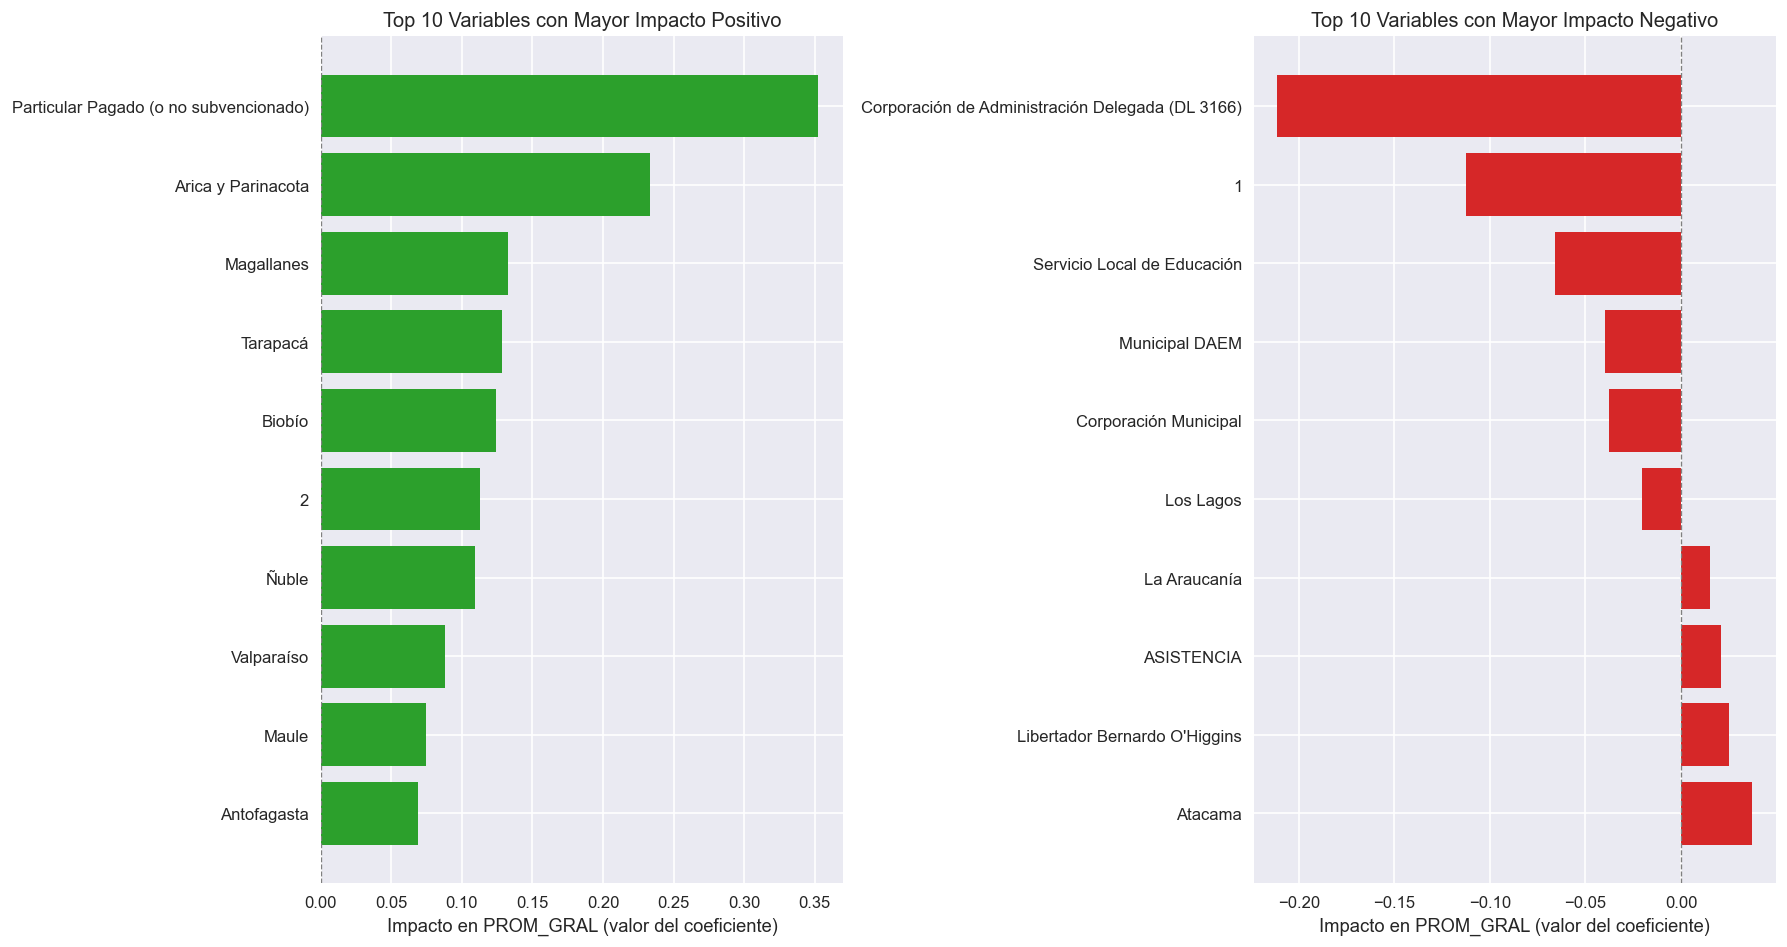

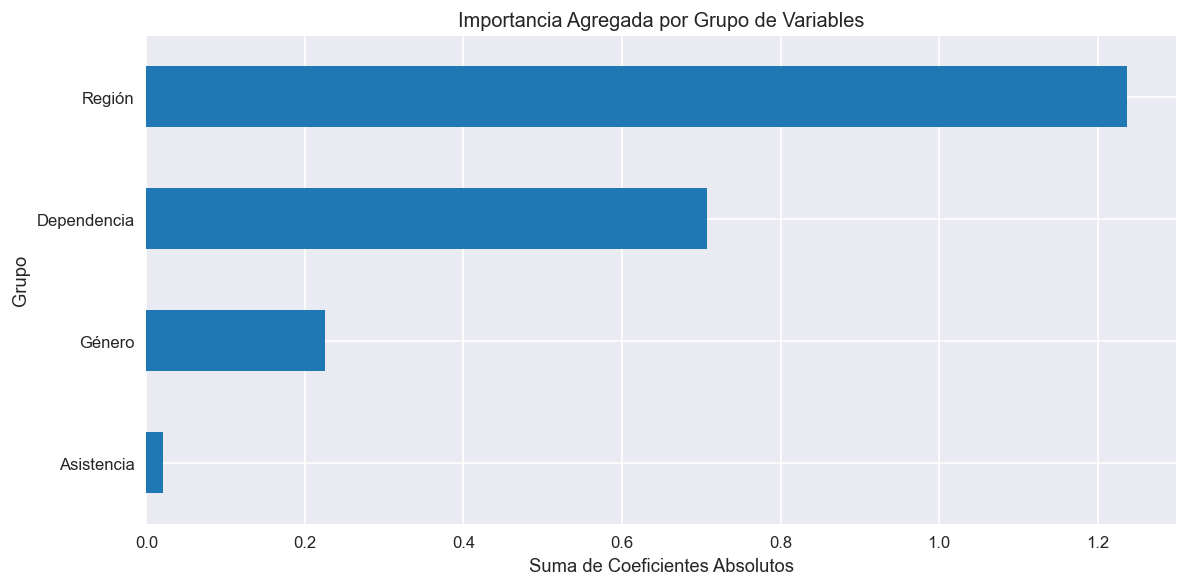

In [29]:
try:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error, r2_score
    import statsmodels.api as sm
    from sklearn.model_selection import train_test_split
except ImportError as exc:
    raise ImportError(
        "Instala scikit-learn (por ejemplo `pip install scikit-learn`) para ejecutar esta celda."
    ) from exc

feature_cols = ["ASISTENCIA"] + region_cols + dep_cols + gender_cols

# Para evitar multicolinealidad, eliminamos una categoría por cada grupo para que sirva de referencia
ref_region = "COD_REG_RBD_Metropolitana"
ref_dep = "COD_DEPE_Particular Subvencionado" # La categoría más común
ref_gender = "GEN_ALU_0" # Sin información

final_region_cols = [c for c in region_cols if c != ref_region]
final_dep_cols = [c for c in dep_cols if c != ref_dep]
final_gender_cols = [c for c in gender_cols if c != ref_gender]

feature_cols_final = ["ASISTENCIA"] + final_region_cols + final_dep_cols + final_gender_cols
model_df = df_valid.dropna(subset=feature_cols_final + ["PROM_GRAL"]).copy()

if len(model_df) > 300_000:
    model_df = model_df.sample(300_000, random_state=RANDOM_STATE)

X = model_df[feature_cols_final]
y = model_df["PROM_GRAL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Intercepto: {linreg.intercept_:.3f}")

# Para obtener los p-values, usamos statsmodels, que está más orientado a la inferencia
print("\n--- Resumen del Modelo (statsmodels) ---")
X_train_sm = sm.add_constant(X_train) # Añadir una constante (intercepto) al modelo
sm_model = sm.OLS(y_train, X_train_sm).fit()
print(sm_model.summary())
print("-----------------------------------------")

# --- Análisis de Coeficientes del Modelo ---
coef_df = pd.DataFrame({"feature": feature_cols_final, "coef": linreg.coef_})

# Limpiar nombres de variables para mejor visualización
def clean_feature_name(name):
    return (
        name.replace("COD_REG_RBD_", "")
        .replace("COD_DEPE_", "")
        .replace("GEN_ALU_", "")
        .replace("Subvencionado", "Subv.")
        .strip()
    )

coef_df["feature_clean"] = coef_df["feature"].apply(clean_feature_name)

# Clasificar variables por grupo
def classify_feature(name):
    if name == "ASISTENCIA": return "Asistencia"
    if name.startswith("COD_DEPE"): return "Dependencia"
    if name.startswith("COD_REG_RBD"): return "Región"
    if name.startswith("GEN_ALU"): return "Género"
    return "Otros"

coef_df["grupo"] = coef_df["feature"].map(classify_feature)
coef_df["abs_coef"] = coef_df["coef"].abs()

# --- Visualización de Importancia de Variables ---
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=False)

# Gráfico 1: Coeficientes más positivos
top_positive = coef_df.nlargest(10, "coef").sort_values("coef")
axes[0].barh(top_positive["feature_clean"], top_positive["coef"], color="#2ca02c")
axes[0].set_title("Top 10 Variables con Mayor Impacto Positivo")
axes[0].set_xlabel("Impacto en PROM_GRAL (valor del coeficiente)")
axes[0].axvline(0, color='grey', linewidth=0.8, linestyle='--')

# Gráfico 2: Coeficientes más negativos
top_negative = coef_df.nsmallest(10, "coef").sort_values("coef", ascending=False)
axes[1].barh(top_negative["feature_clean"], top_negative["coef"], color="#d62728")
axes[1].set_title("Top 10 Variables con Mayor Impacto Negativo")
axes[1].set_xlabel("Impacto en PROM_GRAL (valor del coeficiente)")
axes[1].axvline(0, color='grey', linewidth=0.8, linestyle='--')

plt.tight_layout()
plt.show()

# Gráfico 3: Importancia por grupo de variables
importance_by_group = coef_df.groupby("grupo")["abs_coef"].sum().sort_values()
fig, ax = plt.subplots(figsize=(10, 5))
importance_by_group.plot(kind="barh", ax=ax, color="#1f77b4")
ax.set_title("Importancia Agregada por Grupo de Variables")
ax.set_xlabel("Suma de Coeficientes Absolutos")
ax.set_ylabel("Grupo")
plt.tight_layout()
plt.show()

### 4.1. Importancia de Variables con Métodos Avanzados (Permutation y SHAP)

Para complementar el análisis de coeficientes, aplicaremos dos técnicas más robustas:

1.  **Importancia por Permutación**: Mide cuánto empeora el rendimiento del modelo (R²) si "desordenamos" aleatoriamente los valores de una variable. Una caída grande en el R² significa que la variable es muy importante.
2.  **Valores SHAP**: Es un método basado en teoría de juegos que no solo indica la importancia de una variable, sino también la dirección (positiva o negativa) de su impacto en cada predicción individual.

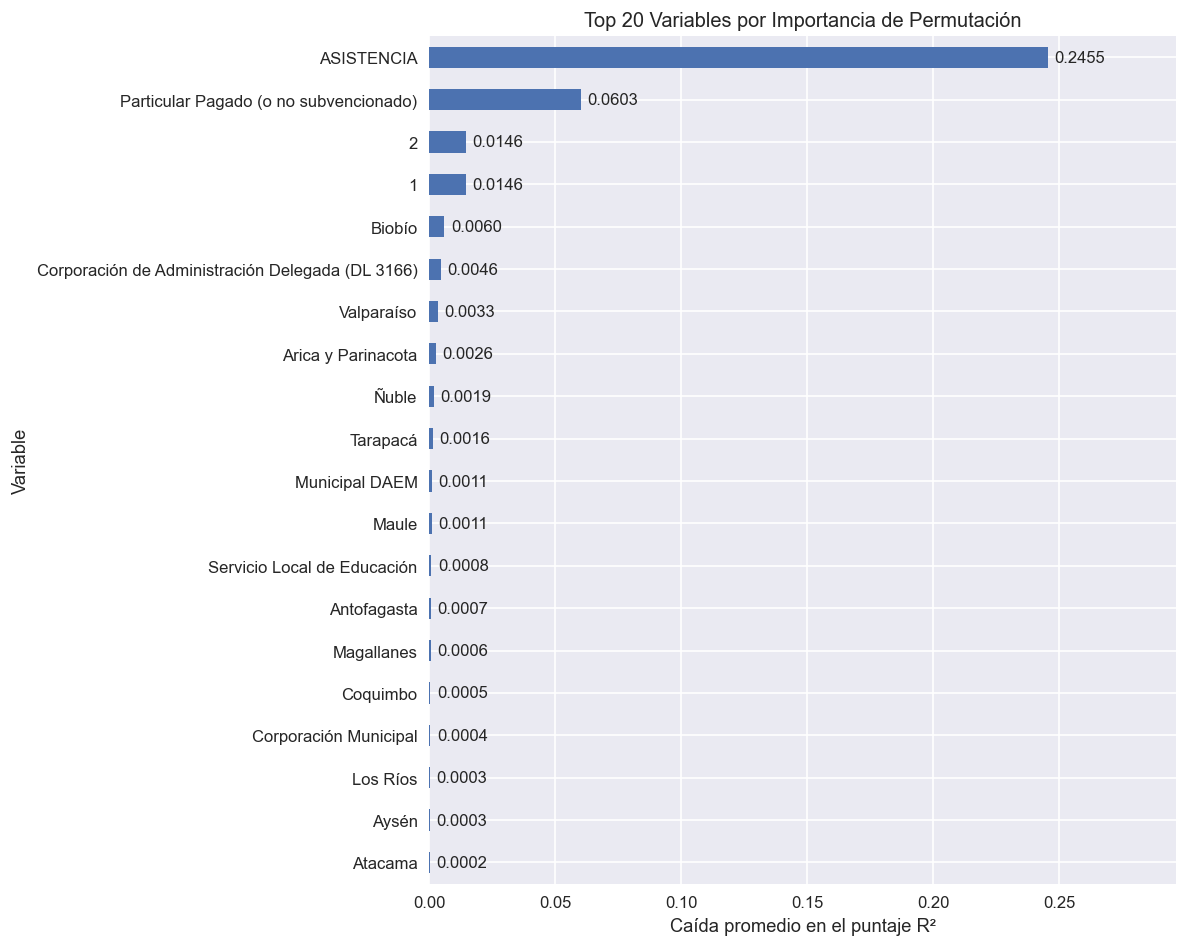


--- Análisis con SHAP ---


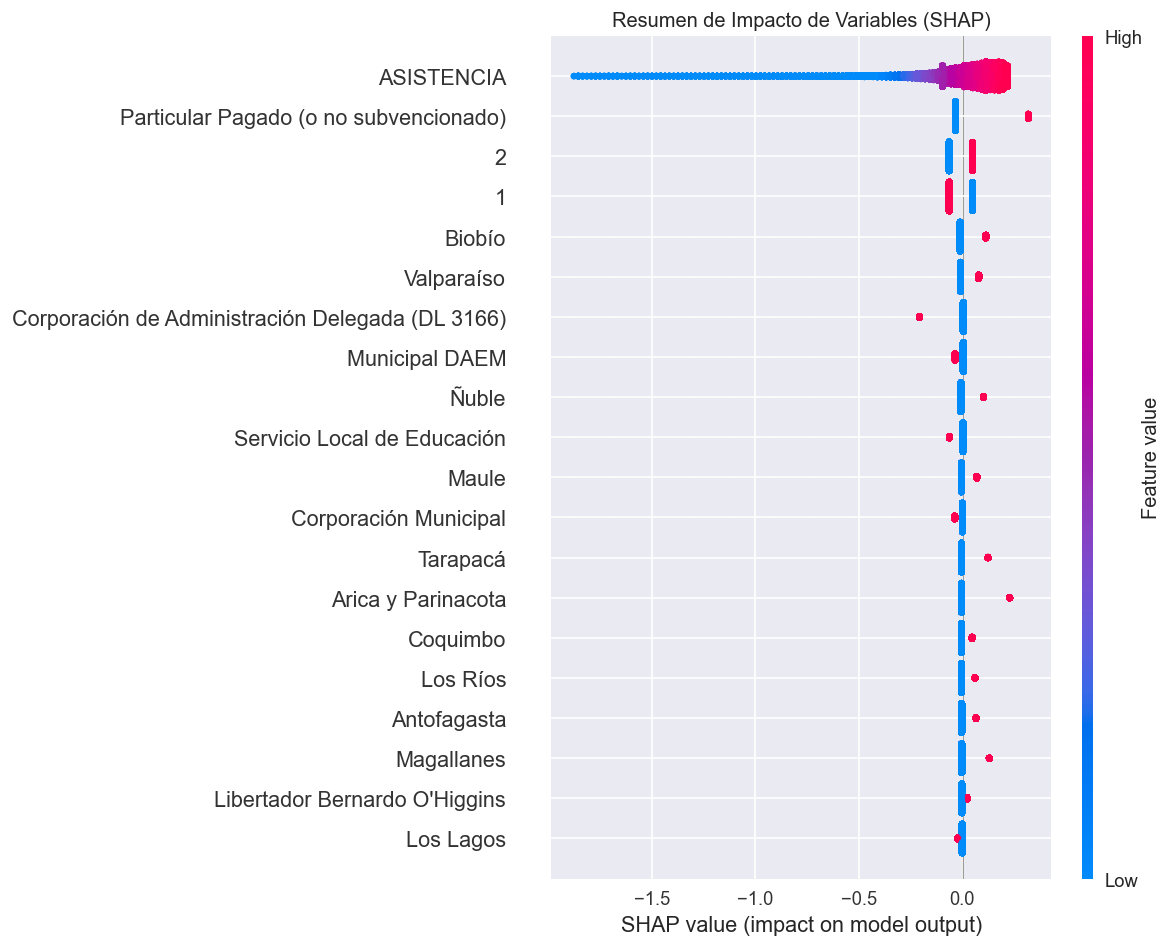

In [30]:
from sklearn.inspection import permutation_importance

try:
    import shap
except ImportError:
    print("Para usar SHAP, instálalo con: pip install shap")
    shap = None

# --- 1. Gráfico de Importancia por Permutación ---
perm_result = permutation_importance(
    linreg, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

# Usamos los nombres limpios de coef_df para el gráfico
perm_importance_df = pd.DataFrame(
    data={"importance_mean": perm_result.importances_mean},
    index=coef_df["feature_clean"],
).sort_values("importance_mean", ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
perm_importance_df.tail(20).plot(kind="barh", ax=ax, legend=False)
ax.set_title("Top 20 Variables por Importancia de Permutación")
ax.set_xlabel("Caída promedio en el puntaje R²")
ax.set_ylabel("Variable")
add_labels_to_barh(ax, fmt="{:.4f}")
plt.tight_layout()
plt.show()

# --- 2. Gráfico de Resumen de SHAP ---
if shap:
    print("\n--- Análisis con SHAP ---")
    # Para modelos lineales, LinearExplainer es el más eficiente
    # Usamos X_train como datos de fondo para el explainer
    explainer = shap.LinearExplainer(linreg, X_train)

    # Calculamos los valores SHAP sobre el conjunto de prueba
    shap_values = explainer(X_test)

    # Reemplazamos los nombres largos por los limpios en los datos de SHAP
    shap_values.feature_names = coef_df.set_index("feature").loc[shap_values.feature_names]["feature_clean"].tolist()

    # Gráfico de resumen (summary plot)
    shap.summary_plot(
        shap_values,
        X_test,
        max_display=20,
        show=False,
        plot_size=(10, 8)
    )
    plt.title("Resumen de Impacto de Variables (SHAP)")
    plt.tight_layout()
    plt.show()
else:
    print("\nSHAP no está instalado. Omitiendo gráfico de SHAP.")

## 5. Conclusiones rápidas

- El 91 % de los registros presenta promedios válidos y se concentran en el tramo 5.5–6.5; sin embargo, un 9 % carece de nota reportada (0), por lo que conviene monitorear la cobertura de calificaciones.
- La asistencia es alta (mediana 91 %), pero un quinto del alumnado cae bajo 90 %, tramo asociado a los promedios más bajos del histograma.
- Se observan brechas claras por dependencia: los establecimientos particulares pagados superan los 6.3 puntos y 92 % de asistencia, mientras que las corporaciones municipales y los SLE rondan 5.8 puntos y 87 % de asistencia.
- Las regiones extremas (Arica y Magallanes) lideran el rendimiento, mientras que Atacama y Los Lagos muestran los niveles más bajos dentro del mapa de calor.
- Las alumnas obtienen ~0.2 puntos más de PROM_GRAL, aunque asisten ligeramente menos; la diferencia se mantiene en todo el espectro de dependencias.
- La correlación asistencia–rendimiento es moderada (0.36 global) y se fortalece en dependencias municipales (≈0.40–0.48), lo que respalda priorizar intervenciones de asistencia en esos segmentos.
- El modelo lineal incluido permite cuantificar el efecto marginal de cada variable y extraer tablas de importancia relativa para guiar futuras simulaciones de política escolar.